# SVM accurary improvement application, suggested by Burges and Schölkopf

In [10]:
## Laboratory conditions for the implementation 

The implementation of the paper proposal is pretty straighforward. The algorithm of the method presented are as followed:
    1) Load a 60,000 + 10,000 MNIST dataset
    2) Do a first classic SVM fit with the training set
    3) Gather the support vectors of the SVM to create artifial examples, by applying to our new training data a       
       translation of the vectors by one pixel in each direction (up, down, left, right)
    4) Apply the new training dataset to the another SVM with the same settings as the first one
    
The laboratory conditions of this experiment to replicate, are as followed:
    - C constant must be equals to 10
    - The kernel we will use be a polynomial (x,y) of degree 5
    - We must use a 60,000 + 10,000 MNIST dataset

## Import packages and librairies

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time



In [12]:
# according to the experimental section of the paper,
# C has for value 10 and they used a polynomial kernel 
C= 10
#since a number from the MNIST Dataset is 28x28 pixels
# we must define row and col
img_w = 28 
img_h = 28


#function for the translation 
def translate (sv,tm):
    """
    translate an image/matrix using a translation Matrix
    Matrix of translation (tm): [[1,0,Tx],[0,1,Ty]
    input : sv->Support vector 
            tm->Matrix of translation
    output: a translated support vector         
    """
    translated = cv2.warpAffine(sv, tm, (img_w, img_h))
    return translated.reshape(-1)


In [13]:
## Import and extract MNIST dataset


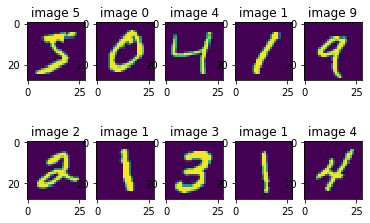

In [14]:
# loading a 60,000+10,000 handwritten digits, from MNIST database


data = np.load("mnist.npz")
training_x = data["x_train"].reshape(60000,img_w*img_h)
training_y = data["y_train"]
test_x = data["x_test"].reshape(10000,img_w*img_h)
test_y = data["y_test"]

# display the first 10 digits of the dataset to check if it is valid
plt.figure(1)
for i in range(10):
    plt.subplot(2, 5, i+1, title=("image " + str(training_y[i])))
    plt.imshow(np.array(training_x[i]).reshape(img_w,img_h))
plt.show()
    

In [15]:
## Initialize SVM objects and translation matrix

In [16]:
# initialize our ORIG SVM for initial SVM and VSV for approximation fit
ORIG = SVC(C=C, kernel="poly", degree=5, gamma="auto")
VSV = SVC(C=C, kernel="poly", degree=5, gamma="auto")

new_training_x = []
new_training_y = []

# initialize transformation matrix to move to 1px in 4 directions
tm_left = np.float32([
  [1, 0, -1],
  [0, 1, 0]
]);

tm_right = np.float32([
  [1, 0, 1],
  [0, 1, 0]
]);

tm_up = np.float32([
  [1, 0, 0],
  [0, 1, -1]
]);

tm_down = np.float32([
  [1, 0, 0],
  [0, 1, 1]
]);

translation_matrix = [
    tm_left, 
    tm_right, 
    tm_up, 
    tm_down]


In [17]:
## Training the SVM objects

In [18]:
# fit the data in the SVM ORIG to train our model and get the supported
# vectors to generate articifical dataset for approximation fit
startORIG = time.time()

ORIG.fit(training_x, training_y)
print("the trainig time for the ORIG model:", time.time()-startORIG)

# Instead of getting the support vectors, we will use their indices
# to retrieve data of MNIST training set at index support vector to
# be shifted
ORIG_vectors = ORIG.support_

# translation of the training set using the generated support vectors of 
# ORIG.
for indice in ORIG_vectors:
    sv = np.uint8(training_x[indice]).reshape(img_w, img_h)
    y = training_y[indice]
    
    new_training_x += [translate(sv, tm) for tm in translation_matrix]
    new_training_y += [y for i in range(4)]

#create virtual support vectors using desired invariance transformation
startVSV = time.time()
VSV.fit(new_training_x, new_training_y)

print("the trainig time for the VSV model:", time.time()-startVSV)

the trainig time for the ORIG model: 353.6377453804016
the trainig time for the VSV model: 417.02598094940186


In [19]:
## Prediction and analysis

In [20]:
# Prediction using the 10,000 test MNIST dataset
ORIG_predictions = ORIG.predict(test_x)
VSV_predictions = VSV.predict(test_x)

# Generate a classification report to have a full depth analysis 
# on classification behaviors
ORIG_report = classification_report(np.array(test_y), ORIG_predictions)
VSV_report = classification_report(np.array(test_y), VSV_predictions)

print("Classification report for ORIG: \n", ORIG_report)
print("\nClassification report for VSV: \n", VSV_report)

# Compare the overall accuracy between ORIG and VSV SVM objects
ORIG_accuracy = accuracy_score(np.array(test_y), ORIG_predictions)
VSV_accuracy = accuracy_score(np.array(test_y), VSV_predictions)

print("ORIG accuracy: ", ORIG_accuracy * 100.0, "%")
print("VSV accuracy: ", VSV_accuracy * 100.0, "%")


Classification report for ORIG: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.93      0.99      0.96      1135
           2       0.98      0.95      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.95      0.96       892
           6       0.97      0.97      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


Classification report for VSV: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.97      0.99      0.98      1135
          

In [21]:
## Result interpretation 


According to the results obtained above, we observe that the VSV 
(SVM object using an artificial training set) has a great consistency in precision for each label, oscilating around 98% of precision.


The SVM ORIG on the other hand has the worst consistency at label "1", with 93% precision. Also, we observe a lack of consistency where the oscilation gap between each label is not negligeable.

In the overall accuracy, VSV shows an increase of 1% from the ORIG approach. 

In conclusion, the approach of the method replicated from the research paper not only has better accuracy, but also adds better consistency to our labelling. We can confirm the validity of the research's paper accuracy improvement